In [1]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import os 
import glob 
import pandas as pd
import medpy.io
from utils import plot_comparison 
%matplotlib inline

/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-package

---

# Training and Validation Data

In [13]:
#path 
storage_path = "/home/kevinteng/Desktop/ssd02/"
#original 
training_ds_path = storage_path+"MICCAI_BraTS2020_TrainingData/"
validation_ds_path = storage_path+"MICCAI_BraTS2020_ValidationData/"
#preprocessed
training_pre = storage_path+"BraTS2020_preprocessed02/Training_pre/"
validation_pre = storage_path+"BraTS2020_preprocessed02/Validation_pre/"

In [16]:
def create_data(input_path, output_path, min_max_norm = False, validation = False, 
                modal_swapaxes = False, label_swapaxes =True, verbose=True):
    if validation==False:
        csv_path = glob.glob(input_path+"name_mapping*.csv")
        csv_file = pd.read_csv(csv_path[0])
        grade = np.array(csv_file["Grade"].tolist()) #csv list with HGG or LGG
        #index grade type from csv
        grade_type = np.unique(grade) #class: HGG or LGG
        #create folder for HGG and LGG
        for types in grade_type:
            HGG_LGG_dir = output_path+"/"+types
            if not os.path.exists(HGG_LGG_dir):
                os.makedirs(HGG_LGG_dir)
    #create directory to store validation data 
    else: #validation == True
        if not os.path.exists(output_path):
            os.makedirs(output_path)
    HGG_count = 0
    LGG_count = 0
    val_count = 0
    for indx, patient in enumerate(sorted(os.listdir(input_path))):
        #patient => (patient id) BraTS20_Training_001
        #ex:/home/kevinteng/Desktop/ssd02/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/
        input_path01 = os.path.join(input_path+patient+"/")
        #for training data
        if not patient.endswith('.csv') and validation==False: #do not need to read .csv files
            #direct path to either HGG or LGG w.r.t patients
            if grade[indx]=='HGG':
                output_path01 = os.path.join(output_path+"/HGG/")
                HGG_count+=1 #increment for HGG 
            else:
                output_path01 = os.path.join(output_path+"/LGG/")
                LGG_count+=1 #increment for LGG
        #for validation data
        elif not patient.endswith('.csv') and validation!=False:
            output_path01 = output_path
            val_count+=1
        else: #skip csv file
            continue
        #create empty numpy array to stack the modals in the last channel
        if validation==False: #last channel would be label for training data 
            multimodal_stack = np.zeros((155,240,240,5), dtype=np.float32)
        else: #validation data has no label
            multimodal_stack = np.zeros((155,240,240,4), dtype=np.float32)
        #loop through the multimodals in each patients
        for multi_modals in sorted(os.listdir(input_path01)): #flair,t1,t1ce,t2
            #'BraTS20_Training_001_flair.nii.gz' => flair
            modal = multi_modals.split('.')[0].split('_')[-1]
            #read imgs
            input_path02 = os.path.join(input_path01+multi_modals)
            read_med_img,_ = medpy.io.load(input_path02)
            img_slices = read_med_img.shape[-1] #last channel is image slices
            #min max normalization switch, label 'seg' not included
            if modal!= 'seg' and min_max_norm==True:
                norm_list = []
                for i in range(img_slices):
                    max_val = np.max(read_med_img[:,:,i]) #max value in that slice
                    min_val = np.min(read_med_img[:,:,i]) #min value of that slice
                    norm = (read_med_img[:,:,i] - min_val)/(max_val-min_val)
                    norm_list.append(norm)
                read_med_img = np.array(norm_list, dtype=np.float32) #=>(155, 240, 240)
                read_med_img = np.nan_to_num(read_med_img)#hacky trick to purge errors
                if modal_swapaxes==True: #=>(240, 240, 155) in case of 3D 
                    read_med_img = np.swapaxes(read_med_img, 0,1)
                    read_med_img = np.swapaxes(read_med_img, 1,2)
                #channel 0 => flair 
                if modal=='flair':
                    multimodal_stack[:,:,:,0] = read_med_img
                #channel 1 => t1
                if modal=='t1':
                    multimodal_stack[:,:,:,1] = read_med_img
                #channel 2 => t1ce
                if modal=='t1ce':
                    multimodal_stack[:,:,:,2] = read_med_img
                #channel 3 => t2
                if modal=='t2':
                    multimodal_stack[:,:,:,3] = read_med_img
            #labels does not need to be normalized 
            if modal== 'seg':
                if label_swapaxes==True: 
                    #(240, 240, 155)=>(155, 240, 240) 
                    # to make the dimension compatible with modalitiy files
                    read_med_img = np.swapaxes(read_med_img, 0,1)
                    read_med_img = np.swapaxes(read_med_img, 0,2)
                #channel 4 => seg (labels)
                multimodal_stack[:,:,:,4] = read_med_img
            save_npy = np.save(output_path01+"/{}.npy".format(patient), multimodal_stack)
    #output info after preprocessing
    if verbose:
        print("Medical image dimensions:{}".format(multimodal_stack.shape))
        if not validation:
            print("HGG patients: {}".format(HGG_count))
            print("LGG patients: {}".format(LGG_count))
            print("Total patients: {}".format(HGG_count + LGG_count))
            print("Total image slices: {}".format((HGG_count + LGG_count)*img_slices))
        else:
            print("Total patients: {}".format(val_count))
            print("Total image slices: {}".format(val_count*img_slices))

In [17]:
#preprocessed training data
create_data(training_ds_path, training_pre, min_max_norm = True)

/home/kevinteng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Medical image dimensions:(155, 240, 240, 5)
HGG patients: 293
LGG patients: 76
Total patients: 369
Total image slices: 57195


## Sanity Check

In [26]:
#preprocessed validation data
create_data(validation_ds_path, validation_pre, min_max_norm = True, validation = True)

/home/kevinteng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Medical image dimensions:(155, 240, 240, 4)
Total patients: 125
Total image slices: 19375


In [43]:
tst_path = '/home/kevinteng/Desktop/ssd02/BraTS2020_preprocessed02/Training_pre/HGG/BraTS20_Training_001.npy'
tst_npy = np.load(tst_path)
print(tst_npy.shape)

(155, 240, 240, 5)


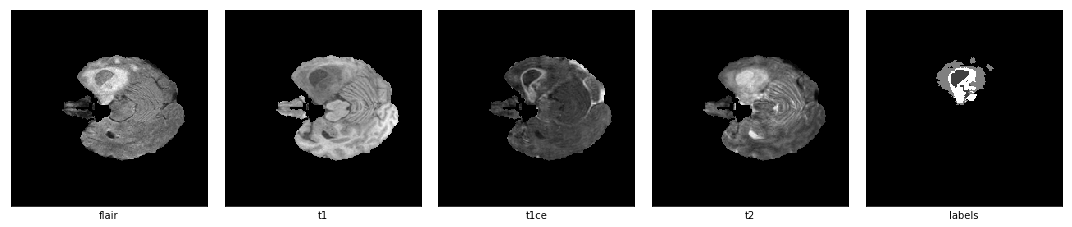

In [34]:
input_img = [tst_npy[50,:,:,i] for i in range(tst_npy.shape[-1])]
caption = ["flair", "t1", "t1ce", "t2", "labels"]
plot_comparison(input_img, caption, n_col = len(caption), figsize=(15,15))

---

# Stack Images 

In [1]:
# def threeD_to_twoD(save_dir, input_path, img_channel=4):
#     '''
#     Stack all the images according to slices of a patient to create a 2D image stacks
    
#     @param save_dir: The directory where the images need to be save
#     @param input_path: The path where pre-processed .npy file is stored 
#     @param img_channel: Image channel from input data
#     '''
#     if not os.path.exists(save_dir):
#         os.makedirs(save_dir)

#     for brain_tumour in sorted(os.listdir(input_path)): #HGG/LGG
#         #create folder for HGG or LGG
#         #only for Training folder since HGG/LGG are not available
#         #for validation dataset
#         #Due to lack of RAM, split HGG into two parts for stacking
#         #max save array =>[150*155,240,240,5] (doesn't exceed 16GB RAM)
#         merge_path_00 = os.path.join(input_path+brain_tumour+"/")
#         #list for each patient*.npy
#         patients = sorted(os.listdir(merge_path_00))
#         n_patients = len(patients)
#         if n_patients>100:#HGG
#             #first 100
#             np_stack00 = np.zeros((100*155,240,240,img_channel), dtype=np.float32)
#             #100~200
#             np_stack01 = np.zeros((100*155,240,240,img_channel), dtype=np.float32)
#             #remainder 293-200 = 93
#             np_stack02 = np.zeros(((n_patients-200)*155, 240,240,img_channel), dtype=np.float32)
#         else:#LGG
#             np_stack00 = np.zeros(((n_patients*155),240,240,img_channel),dtype=np.float32)
#             np_stack01 = 0 #flush RAM from previous storage
#             np_stack02 = 0
#         for idx,patient in enumerate(patients): 
#             merge_path_01 = os.path.join(merge_path_00+patient)
#             med_img = np.load(merge_path_01).astype(np.float32)
#             if idx<100:#first 150
#                 for i in range(med_img.shape[0]): #first dimension is the number of slices
#                     np_stack00[idx*155+i] = med_img[i]
#             if (idx>=100 and idx<200):
#                 for i in range(med_img.shape[0]): #first dimension is the number of slices
#                     np_stack01[(idx-100)*155+i] = med_img[i] 
#             if idx>=200:
#                 for i in range(med_img.shape[0]): #first dimension is the number of slices
#                     np_stack02[(idx-200)*155+i] = med_img[i] 
#         if brain_tumour=='HGG':
#             np.save(save_dir+'{}01_stack.npy'.format(brain_tumour), np_stack00)
#         else:#LGG
#             np.save(save_dir+'{}_stack.npy'.format(brain_tumour), np_stack00)
#         np.save(save_dir+'{}02_stack.npy'.format(brain_tumour), np_stack01)
#         np.save(save_dir+'{}03_stack.npy'.format(brain_tumour), np_stack02)

In [2]:
def threeD_to_twoD(save_dir, input_path, img_channel=4):
    '''
    Stack all the images according to slices of a patient to create a 2D image stacks
    
    @param save_dir: The directory where the images need to be save
    @param input_path: The path where pre-processed .npy file is stored 
    @param img_channel: Image channel from input data
    '''
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for brain_tumour in sorted(os.listdir(input_path)): #HGG/LGG
        #create folder for HGG or LGG
        #only for Training folder since HGG/LGG are not available
        #for validation dataset
        #Due to lack of RAM, split HGG into two parts for stacking
        #max save array =>[150*155,240,240,5] (doesn't exceed 16GB RAM)
        merge_path_00 = os.path.join(input_path+brain_tumour+"/")
        #list for each patient*.npy
        patients = sorted(os.listdir(merge_path_00))
        n_patients = len(patients)
        if brain_tumour=='HGG':
            #0~49
            np_stack00 = np.zeros((50*155,240,240,img_channel), dtype=np.float32)
            for idx in range(50): 
                merge_path_01 = os.path.join(merge_path_00+patients[idx])
                med_img = np.load(merge_path_01).astype(np.float32)
                for i in range(med_img.shape[0]): #first dimension is the number of slices
                    np_stack00[idx*155+i] = med_img[i]
            np.save(save_dir+'{}01_stack.npy'.format(brain_tumour), np_stack00)
            #50~99
            np_stack00 = 0 #flush RAM
            np_stack00 = np.zeros((50*155,240,240,img_channel), dtype=np.float32)
            for idx in range(50,100): #>=100, <200
                merge_path_01 = os.path.join(merge_path_00+patients[idx])
                med_img = np.load(merge_path_01).astype(np.float32)
                for i in range(med_img.shape[0]): #first dimension is the number of slices
                    np_stack00[(idx-50)*155+i] = med_img[i] 
            np.save(save_dir+'{}02_stack.npy'.format(brain_tumour), np_stack00)
            #100~149
            np_stack00 = 0 #flush RAM
            np_stack00 = np.zeros((50*155,240,240,img_channel), dtype=np.float32)
            for idx in range(100,150): 
                merge_path_01 = os.path.join(merge_path_00+patients[idx])
                med_img = np.load(merge_path_01).astype(np.float32)
                for i in range(med_img.shape[0]): #first dimension is the number of slices
                    np_stack00[(idx-100)*155+i] = med_img[i] 
            np.save(save_dir+'{}03_stack.npy'.format(brain_tumour), np_stack00)
            #150~199
            np_stack00 = 0 #flush RAM
            np_stack00 = np.zeros((50*155,240,240,img_channel), dtype=np.float32)
            for idx in range(150,200): 
                merge_path_01 = os.path.join(merge_path_00+patients[idx])
                med_img = np.load(merge_path_01).astype(np.float32)
                for i in range(med_img.shape[0]): #first dimension is the number of slices
                    np_stack00[(idx-150)*155+i] = med_img[i] 
            np.save(save_dir+'{}04_stack.npy'.format(brain_tumour), np_stack00)
            #200~249
            np_stack00 = 0 #flush RAM
            np_stack00 = np.zeros((50*155,240,240,img_channel), dtype=np.float32)
            for idx in range(200,250): 
                merge_path_01 = os.path.join(merge_path_00+patients[idx])
                med_img = np.load(merge_path_01).astype(np.float32)
                for i in range(med_img.shape[0]): #first dimension is the number of slices
                    np_stack00[(idx-200)*155+i] = med_img[i] 
            np.save(save_dir+'{}05_stack.npy'.format(brain_tumour), np_stack00)
            # Remainder 250~293
            np_stack00 = 0 #flush RAM
            np_stack00 = np.zeros(((n_patients-250)*155, 240,240,img_channel), dtype=np.float32)
            for idx in range(250,n_patients):
                merge_path_01 = os.path.join(merge_path_00+patients[idx])
                med_img = np.load(merge_path_01).astype(np.float32)
                for i in range(med_img.shape[0]): #first dimension is the number of slices
                    np_stack00[(idx-250)*155+i] = med_img[i] 
            np.save(save_dir+'{}06_stack.npy'.format(brain_tumour), np_stack00)

        else: #LGG
            np_stack00 = 0
            np_stack00 = np.zeros(((int(n_patients/2)*155),240,240,img_channel),dtype=np.float32)
            for idx in range(int(n_patients/2)): 
                merge_path_01 = os.path.join(merge_path_00+patients[idx])
                med_img = np.load(merge_path_01).astype(np.float32)
                for i in range(med_img.shape[0]): #first dimension is the number of slices
                    np_stack00[idx*155+i] = med_img[i]
            np.save(save_dir+'{}01_stack.npy'.format(brain_tumour), np_stack00)
            #
            np_stack00 = 0
            np_stack00 = np.zeros(((int(n_patients/2)*155),240,240,img_channel),dtype=np.float32)
            for idx in range(int(n_patients/2),n_patients): 
                merge_path_01 = os.path.join(merge_path_00+patients[idx])
                med_img = np.load(merge_path_01).astype(np.float32)
                for i in range(med_img.shape[0]): #first dimension is the number of slices
                    np_stack00[(idx-int(n_patients/2))*155+i] = med_img[i]
            np.save(save_dir+'{}02_stack.npy'.format(brain_tumour), np_stack00)

In [3]:
save_dir = "/home/kevinteng/Desktop/ssd02/BraTS2020_stack02/"
input_path = "/home/kevinteng/Desktop/ssd02/BraTS2020_preprocessed02/Training_pre/"

threeD_to_twoD(save_dir, input_path, img_channel=5)

## Sanity Check

In [4]:
stack_npy = "/home/kevinteng/Desktop/ssd02/BraTS2020_stack02"

for npy in sorted(os.listdir(stack_npy)):
    merge_path = os.path.join(stack_npy, npy)
    tst_npy = 0
    tst_npy = np.load(merge_path)
    print(tst_npy.shape)

(7750, 240, 240, 5)
(7750, 240, 240, 5)
(7750, 240, 240, 5)
(7750, 240, 240, 5)
(7750, 240, 240, 5)
(6665, 240, 240, 5)
(5890, 240, 240, 5)
(5890, 240, 240, 5)


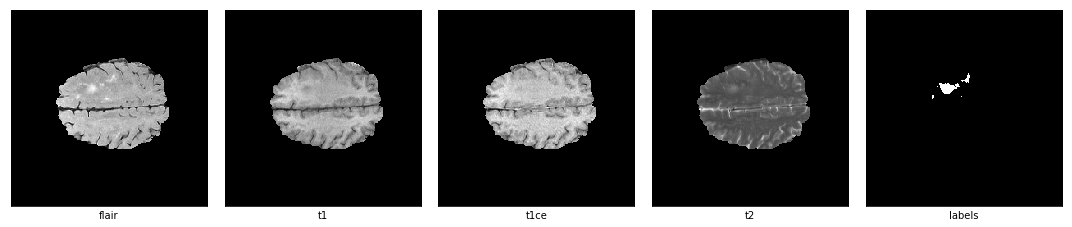

In [12]:
input_img = [tst_npy[1500,:,:,i] for i in range(tst_npy.shape[-1])]
caption = ["flair", "t1", "t1ce", "t2", "labels"]
plot_comparison(input_img, caption, n_col = len(caption), figsize=(15,15))

---

# TF_Records

In [2]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    # If the value is an eager tensor BytesList won't unpack a string from an EagerTensor.
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() 
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_example(image):
    '''
    Adding image and label info to TFRecords dataset
    '''
    feature = {
        'image': _bytes_feature(image)
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

def write_tfrecords(tfrecord_dir, image_paths):
    '''
    write TFRecords to appointed directory 
    '''
    with tf.io.TFRecordWriter(tfrecord_dir) as writer:
        for image in image_paths:
            img_bytes = tf.io.serialize_tensor(image)
            example = serialize_example(img_bytes)
            writer.write(example)
            
def read_tfrecord(serialized_example):
    '''
    read TFRecords from appointed directory 
    '''
    feature_description = {
        'image': tf.io.FixedLenFeature((), tf.string)
    }
    example = tf.io.parse_single_example(serialized_example, feature_description)
    image = tf.io.parse_tensor(example['image'], out_type = float)    
    return image

def parse_tfrecord(tf_dir):
    tfrecord_dataset = tf.data.TFRecordDataset(tf_dir)
    parsed_dataset = tfrecord_dataset.map(read_tfrecord)
    return parsed_dataset

In [3]:
tfrecord_folder = '/home/kevinteng/Desktop/ssd02/BraTS20_tfrecords/'
save_dir = "/home/kevinteng/Desktop/ssd02/BraTS2020_stack02/"
#zip stack images with labels
for stack in sorted(os.listdir(save_dir)): #HGG/LGG
    merge_path_01 = os.path.join(save_dir,stack)
    print(stack)
    if not os.path.exists(tfrecord_folder):
        os.makedirs(tfrecord_folder)
        
    imgs = 0
    imgs = np.load(merge_path_01)
    save_name = stack.split(".")[0]
    tfrecord_dir = tfrecord_folder + save_name +'.tfrecords'
    write_tfrecords(tfrecord_dir, imgs)



HGG01_stack.npy
HGG02_stack.npy
HGG03_stack.npy
HGG04_stack.npy
HGG05_stack.npy
HGG06_stack.npy
LGG01_stack.npy
LGG02_stack.npy


In [4]:
#sanity check
tfrecords_read_dir = '/home/kevinteng/Desktop/ssd02/BraTS20_tfrecords/'
SHUFFLE_BUFFER = 4000
BATCH_SIZE = 16

for tf_re in sorted(os.listdir(tfrecords_read_dir)):
    tf_dir = os.path.join(tfrecords_read_dir+tf_re)
    dataset = parse_tfrecord(tf_dir).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE)
    imgs = next(iter(dataset))
    img = imgs[:,:,:,:4]  
    label = imgs[:,:,:,-1]
    break

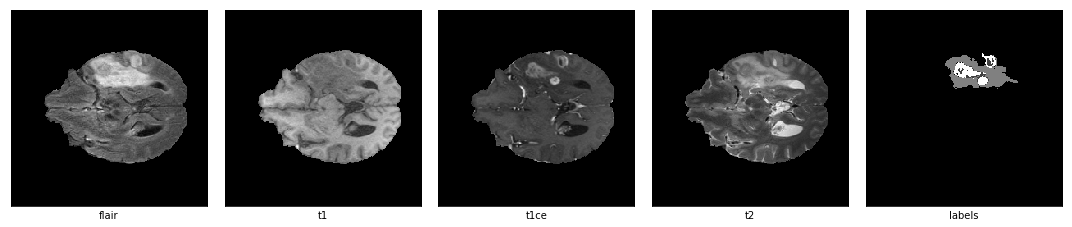

In [12]:
input_img = [img[12,:,:,i] for i in range(img.shape[-1])]
input_img.append(label[12])
caption = ["flair", "t1", "t1ce", "t2", "labels"]
plot_comparison(input_img, caption, n_col = len(caption), figsize=(15,15))